## 素数判定

In [1]:
import math

def is_prime(num):
    for k in range(2, int(math.sqrt(num))):
        if num%k == 0:
            return False
            break
    else: return True

In [2]:
N=20
nlist = [(i,is_prime(i)) for i in range(2,N)]
print(nlist)

[(2, True), (3, True), (4, True), (5, True), (6, True), (7, True), (8, True), (9, True), (10, False), (11, True), (12, False), (13, True), (14, False), (15, True), (16, False), (17, True), (18, False), (19, True)]


## 素数の個数

In [3]:
Num = 3000
checklist = [(k, is_prime(k)) for k in range(2, Num+1)]

plist = [n[0] for n in checklist if n[1]] #= list(filter(lambda x: x[1], checklist))
print("There are {} prime numbers up to {}".format(len(plist), Num))

There are 454 prime numbers up to 3000


## 素数定理

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
bp_n = range(5,Num+1)
bp_p = [len(list(filter((lambda z: z < x), plist))) for x in bp_n]

In [6]:
from sympy import log
bp_y = [x/(log(x)-1.08) for x in bp_n]

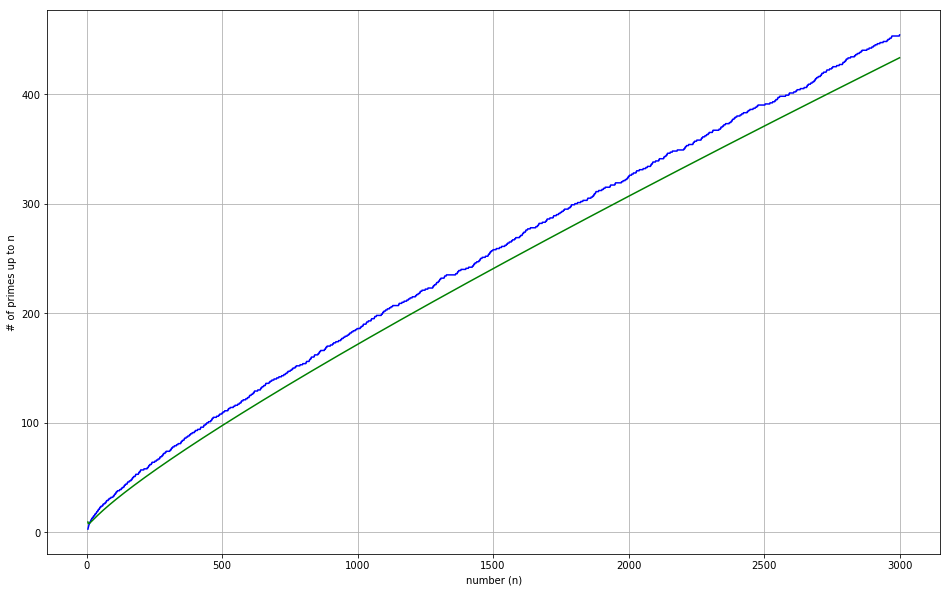

In [8]:
# Make the plot
plt.figure(figsize=(16,10))

ax = plt.subplot()
ax.grid()
ax.set(xlabel='number (n)', ylabel='# of primes up to n')

plt.plot(bp_n, bp_p, color="blue")
plt.plot(bp_n, bp_y, color='green')
plt.show()

## メルセンヌ素数

### メルセンヌ素数を探す

まずは素数判定関数を少し変更

In [9]:
import math
from decimal import *
getcontext()

Context(prec=28, rounding=ROUND_HALF_EVEN, Emin=-999999, Emax=999999, capitals=1, clamp=0, flags=[], traps=[InvalidOperation, DivisionByZero, Overflow])

In [10]:
def find_factor(num):
    getcontext().prec = int(math.log10(num))+2
    for k in range(2, int(math.sqrt(num))+1):
        if Decimal(num)%k == 0:
            return k
            break
    else: return 0
    
def is_prime(num):
    return find_factor(num)==0

In [11]:
from tqdm import tqdm_notebook as tqdm

Num = 60
plist = [n for n in tqdm(range(2,Num+1)) if is_prime(n)]
print(plist)


[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59]


In [12]:
for k in tqdm(plist):
    fac = find_factor(2**k-1)
    if fac == 0:
        print('2^{}-1 = {} is prime'.format(k, 2**k-1))
    else:
        print('2^{}-1 = {} factors into {}*{}'.format(k, 2**k-1, fac, int((2**k-1)/fac)))

2^2-1 = 3 is prime
2^3-1 = 7 is prime
2^5-1 = 31 is prime
2^7-1 = 127 is prime
2^11-1 = 2047 factors into 23*89
2^13-1 = 8191 is prime
2^17-1 = 131071 is prime
2^19-1 = 524287 is prime
2^23-1 = 8388607 factors into 47*178481
2^29-1 = 536870911 factors into 233*2304167
2^31-1 = 2147483647 is prime
2^37-1 = 137438953471 factors into 223*616318177
2^41-1 = 2199023255551 factors into 13367*164511353
2^43-1 = 8796093022207 factors into 431*20408568497
2^47-1 = 140737488355327 factors into 2351*59862819377
2^53-1 = 9007199254740991 factors into 6361*1416003655831
2^59-1 = 576460752303423487 factors into 179951*3203431780337



In [12]:
fac = find_factor(2**61-1); print(fac)

KeyboardInterrupt: 

In [13]:
def find_factor_w_tqdm(num):
    for k in tqdm(range(2, int(math.sqrt(num))+1)):
        if num%k == 0:
            return k
            break
    else: return 0

In [14]:
result = find_factor_w_tqdm(2**61-1); print(result)

Widget Javascript not detected.  It may not be installed or enabled properly.


KeyboardInterrupt: 

### フェルマーテスト

素数判定をもっと高速のものにしたい。まずはフェルマーテスト。

In [13]:
def fermat(num):
    num = abs(num)
    if num == 2: return True
    if num < 2 or num%2 == 0: return False
    return pow(2, num-1, num) == 1

In [14]:
Num = 60
plist = [n for n in tqdm(range(2,Num+1)) if fermat(n)]
print(plist)


[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59]


In [15]:
for k in tqdm(plist):
    if is_prime_alt(2**k-1): print('2^{}-1 = {} is prime'.format(k, 2**k-1))

NameError: name 'is_prime_alt' is not defined

上の出力のように、`2^11-1` や `2^23-1` が素数と判定されてしまった。

### ミラーラビン法

確率的判定法。

In [18]:
import random
def millerrabin(n):
    if n%2 == 0 or n%3 == 0 or n%5 == 0:
        return False
    else:
        s, d = 0, n-1
        while d%2==0: s,d = s+1, int(d/2)
        k = 50
#        for j in tqdm(range(k)):
        while k > 0:
            k = k-1
            a = random.randint(1,n-1)
            t, y = d, pow(a,d,n)
            while t != n-1 and y != 1 and y != n-1:
                y = pow(y,2,n)
                t <<= 1
            if y != n-1 and t%2 == 0:
                return False
        return True

In [ ]:
rst = millerrabin(2**59-1); print(rst)

なぜか、ずいぶん時間がかかってしまう。なぜ?

### リュカ-レーマー・テスト


疑似コード(from Wikipedia)
```
入力: p:奇素数であるテスト対象の整数
出力: PRIME:素数の場合, COMPOSIT:合成数の場合
Lucas_Lehmer_Test_FAST(p):
    var s = 4
    var M = 2p − 1
    for n in range(2, p):
        var sqrt = s × s
        s = (sqrt & m) + (sqrt >> p)
        if s >= m then
            s = s − m
        s = s − 2
    if s == 0 then
        return PRIME
    else
        return COMPOSIT
```

In [16]:
def lucas_lehmer(p):
    s = 4
    mp = (1<<p)-1
    for n in range(2,p):
         s = (s**2-2)%mp
#          sqrt = s*s
#          s = (sqrt & mp) + (sqrt >> p)
#          if s >= mp: s = s-mp
#          s = s-2
    return s==0

In [17]:
lucas_lehmer(11)

False

In [18]:
Num = 10000
plist = [n for n in tqdm(range(2,Num+1)) if is_prime(n)]
print(plist)


[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593, 599, 601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659, 661, 673, 677, 683, 691, 701, 709, 719, 727, 733, 739, 743, 751, 757, 761, 769, 773, 787, 797, 809, 811, 821, 823, 827, 829, 839, 853, 857, 859, 863, 877, 881, 883, 887, 907, 911, 919, 929, 937, 941, 947, 953, 967, 971, 977, 983, 991, 997, 1009, 1013, 1019, 1021, 1031, 1033, 1039, 1049, 1051, 1061, 1063, 1069, 1087, 1091, 1093, 1097, 1103, 1109, 1117, 1123, 1129, 1151, 1153, 1163, 1171, 1181, 1187, 1193, 1201, 1213, 1217, 1

In [19]:
getcontext().prec = 10

for p in tqdm(plist):
    rst = lucas_lehmer(p)
    if rst == True:
        mp = 2**p-1
        nod = math.log10(mp)
        if nod <= 40:
            mp_string = str(mp)
        else:
            mp = Decimal(mp)
            nod = Decimal(mp).adjusted()+1
            getcontext().prec = nod

            top = (Decimal(mp)/(Decimal(10)**(nod-20))).quantize(1)
            bottom = Decimal(mp)-math.floor(Decimal(mp)/Decimal(1.0e+20))*Decimal(1.0e+20)
            mp_string = '{}...{} [{} digits]'.format(top,bottom,nod)
        print('2^{}-1 = {} is prime'.format(p, mp_string))
#     else:
#         print('2^{}-1 = {} factors into {}*{}'.format(k, 2**k-1, fac, int((2**k-1)/fac)))

2^3-1 = 7 is prime
2^5-1 = 31 is prime
2^7-1 = 127 is prime
2^13-1 = 8191 is prime
2^17-1 = 131071 is prime
2^19-1 = 524287 is prime
2^31-1 = 2147483647 is prime
2^61-1 = 2305843009213693951 is prime
2^89-1 = 618970019642690137449562111 is prime
2^107-1 = 162259276829213363391578010288127 is prime
2^127-1 = 170141183460469231731687303715884105727 is prime
2^521-1 = 68647976601306097150...12574028291115057151 [157 digits] is prime
2^607-1 = 53113799281676709869...70835393219031728127 [183 digits] is prime
2^1279-1 = 10407932194664399082...20710555703168729087 [386 digits] is prime
2^2203-1 = 14759799152141802351...50419497686697771007 [664 digits] is prime
2^2281-1 = 44608755718375842957...64133172418132836351 [687 digits] is prime
2^3217-1 = 25911708601320262778...46160677362909315071 [969 digits] is prime
2^4253-1 = 19079700752443907381...76034687815350484991 [1281 digits] is prime
2^4423-1 = 28554254222827961390...10231057902608580607 [1332 digits] is prime
2^9689-1 = 478220278805461